In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np       # linear algebra
import pandas as pd      # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns    # this is only for the heatmap for the confusion matrix
import matplotlib.pyplot as plt

from sklearn import tree
from matplotlib.colors import LinearSegmentedColormap
from sklearn.ensemble  import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [46]:
df_train = pd.read_csv('../input/titanic/train.csv')
df_test = pd.read_csv('../input/titanic/test.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [47]:
# will convert sex to numerical column, 0=M, 1=F
# C = Cherbourg, Q = Queenstown, S = Southampton, [0,1,2]

df_train['Sex'].replace(['male','female'], [0,1], inplace=True)
df_train['Embarked'].replace(['C','Q','S'], [0,1,2], inplace=True)

df_test['Sex'].replace(['male','female'], [0,1], inplace=True)
df_test['Embarked'].replace(['C','Q','S'], [0,1,2], inplace=True)

In [48]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,2.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,0.0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,2.0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,NaN,2.0
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,B42,2.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,NaN,1,2,W./C. 6607,23.4500,NaN,2.0
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.0000,C148,0.0


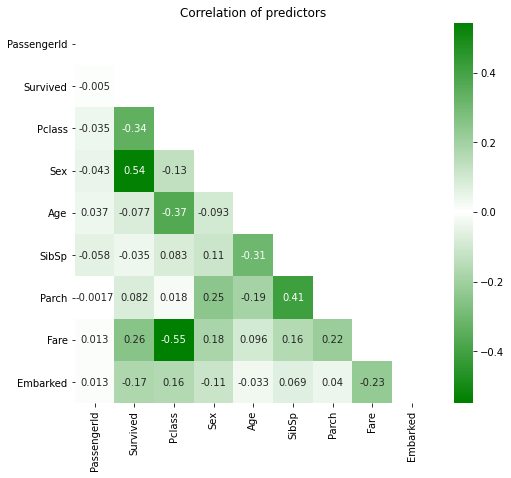

In [49]:
# seeing if there's obvious correlations between predictors
corr = df_train.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(8,7))
sns.heatmap(corr, annot=True, cmap=LinearSegmentedColormap.from_list('gwg',["g", "w", "g"], N=256) , mask=mask, center=0)
plt.title("Correlation of predictors")
plt.show()

# none that massively relate to any others, where PCA might have been useful

In [50]:
col_names = ['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
for i in col_names:
    print(i, df_train[i].isnull().values.any())
    
# there are NaNs present in the age and embarked columns, will just replace with their averages
age_locs = df_train.loc[pd.isna(df_train["Age"]), :].index
age_nans = len(age_locs)

print('')
print('The number of missing ages is', age_nans, 'of a total of', len(df_train["Age"]))
# not really happy replacing 20% of the ages with the bulk average. Will instead opt to take the average of the ticket class, and maybe gender.

PassengerId False
Survived False
Pclass False
Sex False
Age True
SibSp False
Parch False
Fare False
Embarked True

The number of missing ages is 177 of a total of 891


In [52]:
df_age_nans = df_train[pd.isna(df_train["Age"])]
df_age_good = df_train.drop(age_locs)

all_clean_ages = []
for i in range(1,4):
    
    class_mean = (df_age_good[df_age_good.Pclass==i]).Age.mean()
    cleaned_class_ages = df_age_nans[df_age_nans.Pclass==i]['Age'].fillna(class_mean)
    all_clean_ages.append(cleaned_class_ages)

df_train['Age'] = pd.concat([df_age_good['Age'], pd.concat(all_clean_ages)])

In [53]:
#embarked also had some NaNs,
emb_nans = len(df_train.loc[pd.isna(df_train["Embarked"]), :].index) 
print('The number of missing locations is', emb_nans, 'of a total of', len(df_train["Embarked"]))

# 2 is low enough I'll happily replace with an average, might be a mistake later?
df_train['Embarked'].fillna(df_train['Embarked'].mean(), inplace=True)

The number of missing locations is 2 of a total of 891


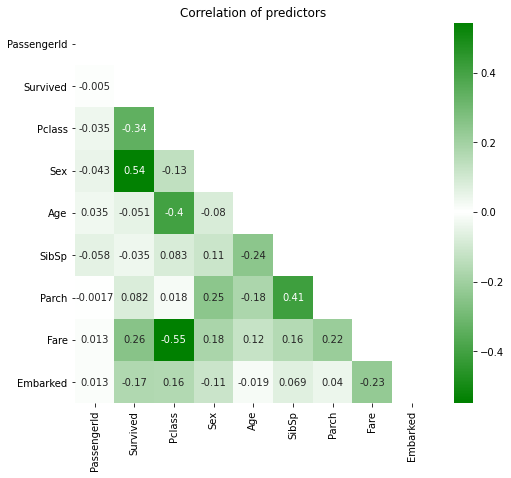

In [67]:
# now it's clean, recheck for own curiosity:

# seeing if there's obvious correlations between predictors
corr = df_train.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(8,7))
sns.heatmap(corr, annot=True, cmap=LinearSegmentedColormap.from_list('gwg',["g", "w", "g"], N=256) , mask=mask, center=0)
plt.title("Correlation of predictors")
plt.show()

# none that massively relate to any others, where PCA might have been useful

In [54]:
col_names_test = ['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
for i in col_names_test:
    print(i, df_test[i].isnull().values.any())
    
# cannot clean the test data through removal, all predictions must be present.
df_test['Age'].fillna(df_test['Age'].mean(), inplace=True)
df_test['Fare'].fillna(df_test['Fare'].mean(), inplace=True)

PassengerId False
Pclass False
Sex False
Age True
SibSp False
Parch False
Fare True
Embarked False


In [55]:
train_y = df_train['Survived'] 
train_X = df_train[['PassengerId','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
train_X.head()

# can ignore the name and ticket columns, will also ignore the cabin column, as it's not massively useful
# could expect emmbarked to be pretty bad as well

#test_y = df_test['Survived'] to be predicted!
test_X = df_test[['PassengerId','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]

In [56]:
#Create the classifier
clf = RandomForestClassifier(n_estimators=500, oob_score=True, max_features="sqrt")        # automatically selects n=sqrt predictors and bagging method

# Fit the tree to training data
clf.fit(train_X,train_y)

RandomForestClassifier(max_features='sqrt', n_estimators=500, oob_score=True)

In [57]:
# Viewing how the trees fit the data

nodes = []
max_depths = []

for single_tree in clf.estimators_:
    nodes.append(single_tree.tree_.node_count)
    max_depths.append(single_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

# Overfitting isn't too much of a problem with random forest, it balances out with each 
# tree fitting to both different features and data samples from the set (bootstrap bagging).

Average number of nodes 349
Average maximum depth 18


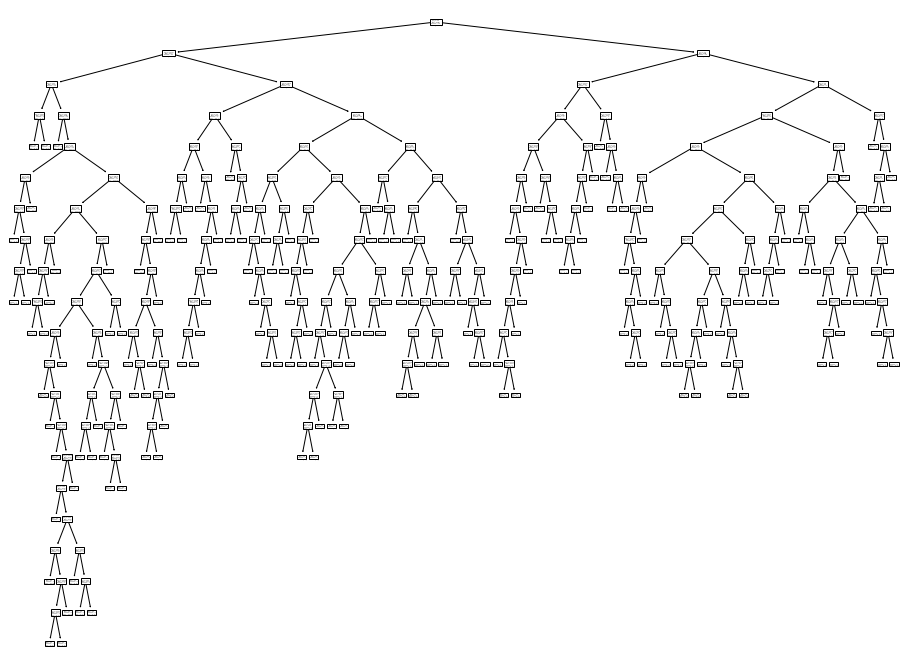

In [58]:
example_tree = clf.estimators_[1]

plt.figure(figsize=(16,12))
tree.plot_tree(example_tree)  
plt.show()

# Although this tree has a lot of nodes and dsefinitely overfits to its particular selection of data and predictors, random forest makes this less important.
# RF takes a combination of all of the trees, reducing variance. The error rate is dependant on the strength of each individual tree and correlation between tree pairs.

In [59]:
# calculate the accuracy of the model to predict the response, in both the initial training set and the test set


train_score = clf.score(train_X, train_y).mean()      # .score just refers to accuracy score - works the same as   accuracy_score(y_test, clf.predict(X_test))
#test_score  = clf.score(test_X, test_y).mean()        

print(f'Training set accuracy score: {train_score:.5f}')
#print(f'Test set accuracy score:     {test_score:.5f}')
print("")


# cross validation is a good score for the capability of the system, 
# the test set isn't much worse than the training set
train_score_cv = cross_val_score(clf, train_X, train_y, cv=5).mean()
#test_score_cv  = cross_val_score(clf, test_X, test_y, cv=5).mean()

print(f'Training set cv score:       {train_score_cv:.5f}')
#print(f'Test set cv score:           {test_score_cv:.5f}')
print("")


# RF can produce the out of bag (OOB) score too.
# OOB does not use the test set, it just looks at the training set and takes ~37% of those as OOB for comparison.
# It would be better if I didn't/couldn't split into train and test, but because the set looks big enough to split fairly (~6500), it's better to use the cv score
print(f'OOB score:                   {clf.oob_score_:.5f}')   

Training set accuracy score: 1.00000

Training set cv score:       0.79921

OOB score:                   0.82043


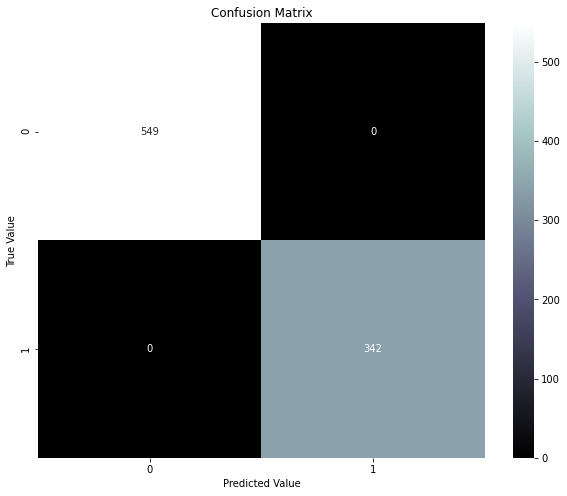

In [60]:
# best way to view the problems with the system is to see the confusion matrix,

test_y_pred = clf.predict(test_X)
train_y_pred = clf.predict(train_X)

clf_matrix = confusion_matrix(train_y, train_y_pred)

# true neg   |  false pos
# false neg  |  true pos

# visualized nicely
plt.figure(figsize=(10,8))
sns.heatmap(clf_matrix, annot=True, cmap="bone",fmt='.0f')
plt.title("Confusion Matrix")
plt.ylabel("True Value")
plt.xlabel("Predicted Value")
plt.show()

In [61]:
print(classification_report(train_y, train_y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       549
           1       1.00      1.00      1.00       342

    accuracy                           1.00       891
   macro avg       1.00      1.00      1.00       891
weighted avg       1.00      1.00      1.00       891



In [62]:
n_estimators = [*range(400,800,100)]              # number of trees generated in the forest

max_depth = [*range(2,10,2)]                       # average depth of initial set was ~20
max_depth.append(None)                             # allows no-limit of max depth to occur as well

min_samples_leaf  = [2, 3, 5]                      # Minimum number of samples required at each leaf node, won't split the node above if it can't do this
min_samples_split = [2, 3, 5]                      # Minimum number of samples required to split a node

grid = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split,}


#clf_random = RandomizedSearchCV(estimator=RandomForestClassifier(oob_score=True, max_features="sqrt"), param_distributions=grid, n_iter=40, cv=3, random_state=1, n_jobs=-1)
clf_random = GridSearchCV(estimator=RandomForestClassifier(oob_score=True, max_features="sqrt"), param_grid=grid, cv=3, n_jobs=-1)
clf_random.fit(train_X,train_y)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_features='sqrt',
                                              oob_score=True),
             n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8, None],
                         'min_samples_leaf': [2, 3, 5],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [400, 500, 600, 700]})

In [63]:
best_params = clf_random.best_params_
print(best_params)
print("")

clf_improved = RandomForestClassifier(**clf_random.best_params_, oob_score=True, max_features="sqrt", random_state=1)             # passes these best parameters directly back to the model
clf_improved.fit(train_X,train_y)

y_train_predicted_improved = clf_improved.predict(train_X)
y_test_predicted_improved  = clf_improved.predict(test_X)

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 600}



In [64]:
y_test_predicted_improved

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [65]:
d = {'PassengerId':df_test['PassengerId'], 'Survived':y_test_predicted_improved}

In [66]:
gender_sub_df = pd.DataFrame(data=d)
gender_sub_df.to_csv('gender_submission_1.csv',index=False)